### Les Miserables, combo style (experimental)

This example demonstrates a layout that gruops together related nodes - typically by category - and connects them based on the aggregate weights of their links.

We use the [Les Miserables dataset](http://www.casos.cs.cmu.edu/computational_tools/datasets/external/lesmis/), originating from [Knuth et al](https://www.semanticscholar.org/paper/The-Stanford-GraphBase-a-platform-for-combinatorial-Knuth/77eb30495093bfe10929e7847d9d04ec41409846).

To group the Les Mis characters, we pick the handy [Louvain algorithm](https://en.wikipedia.org/wiki/Louvain_method) for community detection. We aren't too interested in turning the dials here, we just want some node groupings here to visualise, and Louvain gives us that out of the box.

In [1]:
import sys
import altair as alt
import networkx as nx
import numpy as np
import pandas as pd
from faker import Faker

".." not in sys.path and sys.path.append("..")
from alph import alph, layers, layout, util

util.set_altair_renderer()

Start by loading the data to create a graph. Then add node names as an explicit attribute for use later (node names serve as node ids in the dataset).

In [2]:
G = nx.read_gml("data/lesmis.gml")
max_edge_value = max([d[2] for d in G.edges(data="value")])
nx.set_node_attributes(G, {n: n for n in G.nodes()}, "name")

print(f"nodes: {len(G.nodes())}, links: {len(G.edges())}, max edge value: {max_edge_value}")

nodes: 77, links: 254, max edge value: 31


Perform community detection using the Louvain method, and assign each node to its group via an attribute.

In [3]:
seed = 42

communities = nx.algorithms.community.louvain_communities(G, weight="value", resolution=1, seed=seed)
node_to_group = {n: str(c) for c, ns in enumerate(communities) for n in ns}
nx.set_node_attributes(G, node_to_group, "group")

print(list(node_to_group.items())[:3])

[('MlleBaptistine', '0'), ('Champtercier', '0'), ('CountessDeLo', '0')]


Let's now plot the Les Mis graph, before combo styling. We'll set node colours based on the group attribute.

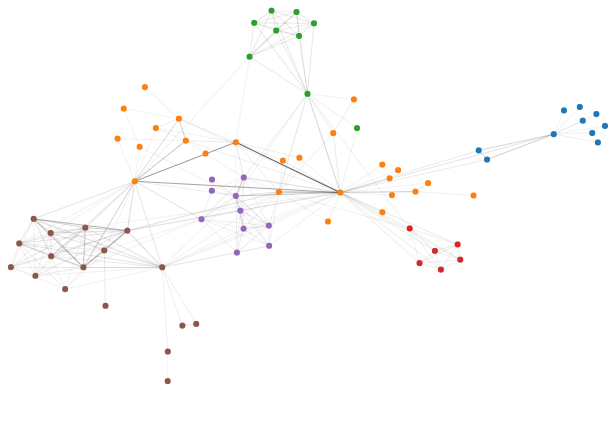

In [4]:
alph(
    G,
    weight_attr="value",
    layout_fn=lambda g: layout.force_atlas(
        g, gravity=8, outboundAttractionDistribution=False,  iterations=1000, seed=seed
    ),
    node_args=dict(
        size=alt.value(6**2),
        fill=alt.Color("group", scale=alt.Scale(scheme="category10"), legend=None),
        tooltip_attrs=["name", "group"]
    ),
    edge_args=dict(
        color="#333",
        opacity=alt.Size(
            "value:Q",
            scale=alt.Scale(domain=[0,max_edge_value], range=[0.5, 0.8]),
            legend=None
        ),
        strokeWidth=alt.Size(
            "value:Q",
            scale=alt.Scale(domain=[0,max_edge_value], range=[0.1, 1]),
            legend=None
        ),
    ),
).configure_view(strokeWidth=0).properties(width=600, height=420)

Now prepare to plot the combo charts. Here we've wrapped the invocation inside a function, so we can easily try a couple of different layouts.

This feature is experimental, requiring a bit of tuning to get decent-looking results. So it's worth noting a few things:
- `combo_group_by` is the attribute to use to group the nodes
- `layout_fn`, `node_args` and `edge_args` refer to the layout and style of graphs inside the group nodes
- analogously, `combo_layout_fn`, `combo_node_args` and `combo_edge_args` refer to the layout and style of the larger group nodes themselves; note how we've used `alt.condition` to highlight one of the edges
- `combo_node_additional_attrs` is a way to pass additional attributes to group-level nodes, so they can be referenced from `node_args` / `edge_args`
- `combo_size_scale_range` is the range of sizes (remember, shape size values reflect the area, not the radius / edge) for the combo nodes; this is scaled based on the number of nodes in each group
- `combo_inner_graph_scale_factor` sets how big the group-level graphs (the ones inside the combo nodes) should be, as a fraction of the overall combo node size; values around 0.5 are typical
- `combo_empty_attr_action` describes how to handle nodes without the group attribute; they can be dropped (`drop`), treated as additional one-per-node categories (`group`), or promoted to a combo category for each item (`promote`).

In [5]:
nx.set_edge_attributes(G, {(u,v): w for u, v, w in G.edges(data="value")}, "weight")
groups = list(set([x[1] for x in G.nodes(data="group")]))

def combo_chart(layout_fn):
    return alph(
        G,
        weight_attr="value",
        layout_fn=layout_fn,
        node_args=dict(
            size=5**2,
            fill="#888",
            stroke="#222",
            strokeWidth=1,
            tooltip_attrs=["name", "group"],
        ),
        edge_args=dict(
            color="#333",
            opacity=alt.Size(
                "value:Q",
                scale=alt.Scale(range=[0.5, 0.8]),
                legend=None
            ),
            strokeWidth=alt.Size(
                "value:Q",
                scale=alt.Scale(range=[0.4, 1]),
                legend=None
            ),
        ),
        combo_group_by="group",
        combo_layout_fn=lambda g: layout.force_atlas(
            g,
            weight_attr="value",
            strongGravityMode=True,
            gravity=6,
            edgeWeightInfluence=1.2,
            seed=seed,
        ),
        combo_node_additional_attrs={
            group: {"group": group or ""} for group in groups
        },
        combo_node_args=dict(
            fill="#fff",
            tooltip_attrs=["group:N"],
            label_attr="group:N",
            label_offset=12,
        ),
        combo_edge_args=dict(
            strokeWidth=alt.Size("value", scale=alt.Scale(range=[0.5, 3]), legend=None),
            color=alt.condition(
                (alt.datum.source == "1") & (alt.datum.target == "2"),
                alt.value("blue"),
                alt.value("#999"),
            ),
        ),
        combo_size_scale_range=[40**2,100**2],
        combo_inner_graph_scale_factor=0.6,
        combo_empty_attr_action="promote",
        width=600,
        height=480,
    ).configure_view(strokeWidth=0)

First, plot using a force-based layout. This mostly results in nice group-level layouts, especially when the number of nodes isn't particularly large.

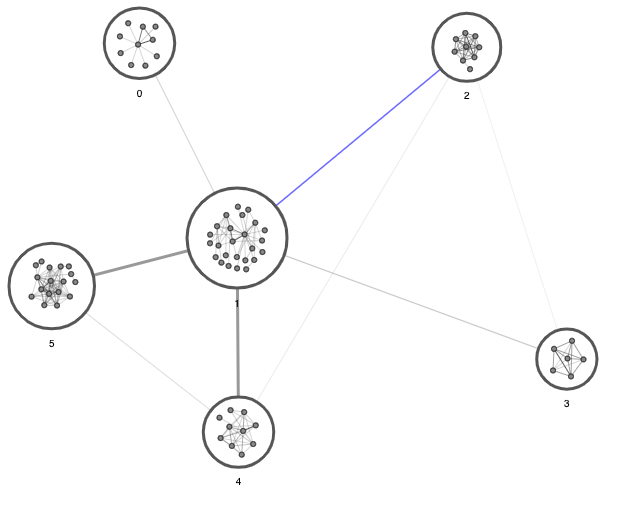

In [6]:
combo_chart(
    layout_fn=lambda g: layout.force_atlas(
        g,
        weight_attr="weight",
        strongGravityMode=True,
        outboundAttractionDistribution=False,
        gravity=5,
        seed=seed,
    ),
)

And now use a different layout for group-level graphs. This is a little tidier,
at the expense of connection patterns being slightly harder to spot.

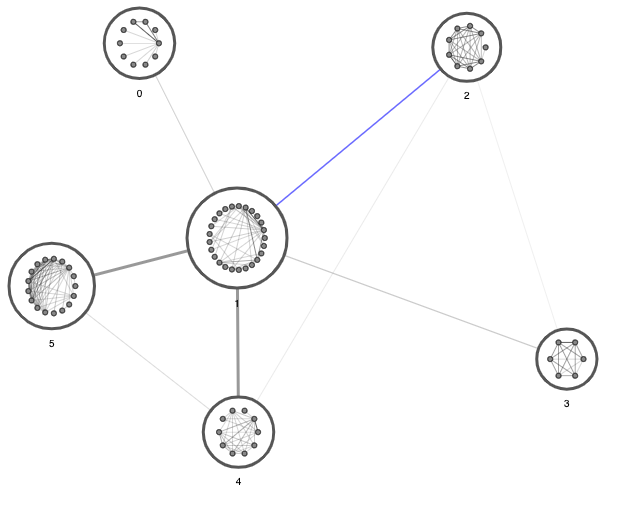

In [7]:
combo_chart(layout_fn=nx.circular_layout)